In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

## Séries históricas disponíveis em
## http://www.b3.com.br/pt_br/market-data-e-indices/servicos-de-dados/market-data/historico/mercado-a-vista/series-historicas/
arquivo_bovespa = '../COTAHIST_M102022.TXT'


## Estrutura do arquivo disponível em 
## http://www.b3.com.br/data/files/33/67/B9/50/D84057102C784E47AC094EA8/SeriesHistoricas_Layout.pdf
tamanho_campos=[2,8,2,12,3,12,10,3,4,13,13,13,13,13,13,13,5,18,18,13,1,8,7,13,12,3]

dados_acoes=pd.read_fwf(arquivo_bovespa, widths=tamanho_campos, header=0)
dados_acoes

,00,COTAHIST,.2,022BOVESPA 2,022,1031,Unnamed: 6,Unnamed: 7,Unnamed: 8,Unnamed: 9,...,Unnamed: 16,Unnamed: 17,Unnamed: 18,Unnamed: 19,Unnamed: 20,Unnamed: 21,Unnamed: 22,Unnamed: 23,Unnamed: 24,Unnamed: 25
0,1,20221003,2.0,ELMD3,10,ELETROMIDIA,ON NM,NaN,R$,1080.0,...,680.0,216300.0,2.469914e+08,0.0,0.0,99991231.0,1.0,0.0,BRELMDACNOR3,100.0
1,1,20221003,2.0,OFSA3,10,OUROFINO S/A,ON NM,NaN,R$,2317.0,...,37.0,7300.0,1.664580e+07,0.0,0.0,99991231.0,1.0,0.0,BROFSAACNOR7,114.0
2,1,20221003,2.0,SMFT3,10,SMART FIT,ON NM,NaN,R$,1568.0,...,8482.0,1950600.0,3.148693e+09,0.0,0.0,99991231.0,1.0,0.0,BRSMFTACNOR1,109.0
3,1,20221003,2.0,HOME34,10,HOME DEPOT,DRN,NaN,R$,5253.0,...,494.0,27860.0,1.467964e+08,0.0,0.0,99991231.0,1.0,0.0,BRHOMEBDR002,143.0
4,1,20221003,2.0,BRGE3,10,ALFA CONSORC,ON,NaN,R$,995.0,...,2.0,200.0,1.912000e+05,0.0,0.0,99991231.0,1.0,0.0,BRBRGEACNOR6,203.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
181802,1,20221019,78.0,ITSAI99,70,ITSA,PN N1,0.0,R$,243.0,...,3.0,1500.0,3.639000e+05,906.0,0.0,20230915.0,1.0,0.0,BRITSAACNPR7,412.0
181803,1,20221021,78.0,ITSAI99,70,ITSA,PN N1,0.0,R$,268.0,...,1.0,500.0,1.340000e+05,906.0,0.0,20230915.0,1.0,0.0,BRITSAACNPR7,412.0
181804,1,20221024,78.0,ITSAI99,70,ITSA,PN N1,0.0,R$,259.0,...,1.0,1000.0,2.590000e+05,906.0,0.0,20230915.0,1.0,0.0,BRITSAACNPR7,412.0
181805,1,20221025,78.0,ITSAI99,70,ITSA,PN N1,0.0,R$,255.0,...,4.0,1100.0,2.794000e+05,906.0,0.0,20230915.0,1.0,0.0,BRITSAACNPR7,412.0


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Pré-processamento dos dados 

#### Etapa 1 - Estruturação

 

##### Nomeação de colunas, eliminação da última linha e ajustes de valores com vírgula

In [ ]:
## Nomear as colunas

dados_acoes.columns = [
"tipo_registro",
"data_pregao",
"cod_bdi",
"cod_negociacao",
"tipo_mercado",
"empresa",
"especificacao_papel",
"prazo_dias_merc_termo",
"moeda_referencia",
"preco_abertura",
"preco_maximo",
"preco_minimo",
"preco_medio",
"preco_ultimo_negocio",
"preco_melhor_oferta_compra",
"preco_melhor_oferta_venda",
"numero_negocios",
"quantidade_papeis_negociados",
"volume_total_negociado",
"preco_exercicio",
"ìndicador_correcao_precos",
"data_vencimento" ,
"fator_cotacao",
"preco_exercicio_pontos",
"codigo_isin",
"num_distribuicao_papel"]

# Eliminar a última linha
linha=len(dados_acoes["data_pregao"])
dados_acoes=dados_acoes.drop(linha-1)

# Ajustar valores com virgula (dividir os valores dessas colunas por 100)
listaVirgula=[
"preco_abertura",
"preco_maximo",
"preco_minimo",
"preco_medio",
"preco_ultimo_negocio",
"preco_melhor_oferta_compra",
"preco_melhor_oferta_venda",
"volume_total_negociado",
"preco_exercicio",
"preco_exercicio_pontos"
]

for coluna in listaVirgula:
    dados_acoes[coluna]=[i/100. for i in dados_acoes[coluna]]


,tipo_registro,data_pregao,cod_bdi,cod_negociacao,tipo_mercado,empresa,especificacao_papel,prazo_dias_merc_termo,moeda_referencia,preco_abertura,...,numero_negocios,quantidade_papeis_negociados,volume_total_negociado,preco_exercicio,ìndicador_correcao_precos,data_vencimento,fator_cotacao,preco_exercicio_pontos,codigo_isin,num_distribuicao_papel
0,1,20221003,2.0,ELMD3,10,ELETROMIDIA,ON NM,NaN,R$,10.80,...,680.0,216300.0,2469914.0,0.00,0.0,99991231.0,1.0,0.0,BRELMDACNOR3,100.0
1,1,20221003,2.0,OFSA3,10,OUROFINO S/A,ON NM,NaN,R$,23.17,...,37.0,7300.0,166458.0,0.00,0.0,99991231.0,1.0,0.0,BROFSAACNOR7,114.0
2,1,20221003,2.0,SMFT3,10,SMART FIT,ON NM,NaN,R$,15.68,...,8482.0,1950600.0,31486931.0,0.00,0.0,99991231.0,1.0,0.0,BRSMFTACNOR1,109.0
3,1,20221003,2.0,HOME34,10,HOME DEPOT,DRN,NaN,R$,52.53,...,494.0,27860.0,1467963.7,0.00,0.0,99991231.0,1.0,0.0,BRHOMEBDR002,143.0
4,1,20221003,2.0,BRGE3,10,ALFA CONSORC,ON,NaN,R$,9.95,...,2.0,200.0,1912.0,0.00,0.0,99991231.0,1.0,0.0,BRBRGEACNOR6,203.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
181801,1,20221018,78.0,ITSAI99,70,ITSA,PN N1,0.0,R$,2.37,...,1.0,1000.0,2370.0,9.06,0.0,20230915.0,1.0,0.0,BRITSAACNPR7,412.0
181802,1,20221019,78.0,ITSAI99,70,ITSA,PN N1,0.0,R$,2.43,...,3.0,1500.0,3639.0,9.06,0.0,20230915.0,1.0,0.0,BRITSAACNPR7,412.0
181803,1,20221021,78.0,ITSAI99,70,ITSA,PN N1,0.0,R$,2.68,...,1.0,500.0,1340.0,9.06,0.0,20230915.0,1.0,0.0,BRITSAACNPR7,412.0
181804,1,20221024,78.0,ITSAI99,70,ITSA,PN N1,0.0,R$,2.59,...,1.0,1000.0,2590.0,9.06,0.0,20230915.0,1.0,0.0,BRITSAACNPR7,412.0


##### Tipos de dados

In [ ]:
## Informações das variáveis
dados_acoes.info()

## Corrigir tipos de dados
dados_acoes["data_pregao"]  = pd.to_datetime(dados_acoes["data_pregao"],infer_datetime_format=True) #Transforma para o tipo datetime64
dados_acoes["cod_negociacao"] = dados_acoes["cod_negociacao"].astype('|S') #Transforma o objeto em string
dados_acoes["empresa"] = dados_acoes["cod_negociacao"].astype('|S') #Transforma o objeto em string
dados_acoes["codigo_isin"] = dados_acoes["codigo_isin"].astype('|S') #Transforma o objeto em string


dados_acoes.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 181806 entries, 0 to 181805
Data columns (total 26 columns):
 #   Column                        Non-Null Count   Dtype  
---  ------                        --------------   -----  
 0   tipo_registro                 181806 non-null  int64  
 1   data_pregao                   181806 non-null  object 
 2   cod_bdi                       181806 non-null  float64
 3   cod_negociacao                181806 non-null  object 
 4   tipo_mercado                  181806 non-null  int64  
 5   empresa                       181806 non-null  object 
 6   especificacao_papel           181806 non-null  object 
 7   prazo_dias_merc_termo         148349 non-null  float64
 8   moeda_referencia              181806 non-null  object 
 9   preco_abertura                181806 non-null  float64
 10  preco_maximo                  181806 non-null  float64
 11  preco_minimo                  181806 non-null  float64
 12  preco_medio                   181806 non-nul

#### Etapa 2 - Remoção de Dados Faltantes

In [ ]:
#Identificar dados faltantes
dados_acoes.isnull().sum()

tipo_registro                       0
data_pregao                         0
cod_bdi                             0
cod_negociacao                      0
tipo_mercado                        0
empresa                             0
especificacao_papel                 0
prazo_dias_merc_termo           33457
moeda_referencia                    0
preco_abertura                      0
preco_maximo                        0
preco_minimo                        0
preco_medio                         0
preco_ultimo_negocio                0
preco_melhor_oferta_compra          0
preco_melhor_oferta_venda           0
numero_negocios                     0
quantidade_papeis_negociados        0
volume_total_negociado              0
preco_exercicio                     0
ìndicador_correcao_precos           0
data_vencimento                     0
fator_cotacao                       0
preco_exercicio_pontos              0
codigo_isin                         0
num_distribuicao_papel              0
dtype: int64

In [ ]:
## Remover dados faltantes
dados_acoes = dados_acoes.dropna(axis=1)
dados_acoes.isnull().sum()

tipo_registro                   0
data_pregao                     0
cod_bdi                         0
cod_negociacao                  0
tipo_mercado                    0
empresa                         0
especificacao_papel             0
moeda_referencia                0
preco_abertura                  0
preco_maximo                    0
preco_minimo                    0
preco_medio                     0
preco_ultimo_negocio            0
preco_melhor_oferta_compra      0
preco_melhor_oferta_venda       0
numero_negocios                 0
quantidade_papeis_negociados    0
volume_total_negociado          0
preco_exercicio                 0
data_vencimento                 0
fator_cotacao                   0
codigo_isin                     0
num_distribuicao_papel          0
dtype: int64

##### Representação Gráfica e Análise Descritiva

In [ ]:
def removeNoiseData(df , column , rwidth):
  plt.hist(x = column , rwidth = rwidth)
  column_data = {
    "mode" : column.mode() ,
    "mean" : column.mean() ,
    "median" : column.median()
}
  if(column_data["mode"] == 0 and column_data["mean"] == 0 and column_data["median"] == 0):
    df = df(column , axis = "columns")
  return plt.hist(x = column , rwidth = rwidth) , column_data

## Corrigir


###### Análise da coluna Indicadores de Correção de Preços

{'mode': 0    0.0
dtype: float64, 'mean': 0.0, 'meadian': 0.0}


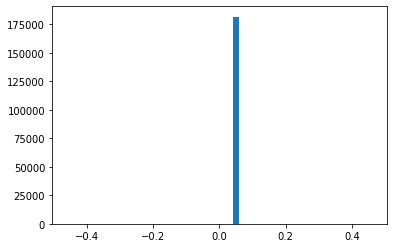

In [ ]:
# Parecem haver dados ruidosos aqui
plt.hist(x = dados_acoes["ìndicador_correcao_precos"], rwidth = 0.2)
indicador_correcao_precos = {
    "mode" : dados_acoes["ìndicador_correcao_precos"].mode() ,
    "mean" : dados_acoes["ìndicador_correcao_precos"].mean() ,
    "meadian" : dados_acoes["ìndicador_correcao_precos"].median()
}
# Essa coluna não revela nada relevante
print(indicador_correcao_precos)
#Remoção da coluna dados_acoes["ìndicador_correcao_precos"]
dados_acoes = dados_acoes.drop(["ìndicador_correcao_precos"], axis = "columns")

###### Análise da coluna "preco_exercicio_pontos"

{'mode': 0    0.0
dtype: float64, 'mean': 16459467.784341551, 'meadian': 0.0}


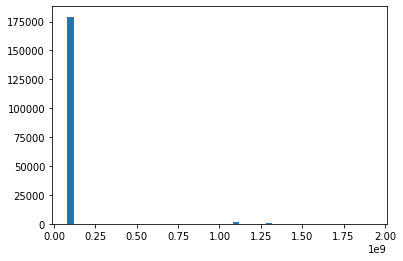

In [ ]:
# Parecem haver dados ruidosos aqui
plt.hist(x = dados_acoes["preco_exercicio_pontos"], rwidth = 0.2)
preco_exercicio_pontos = {
    "mode" : dados_acoes["preco_exercicio_pontos"].mode() ,
    "mean" : dados_acoes["preco_exercicio_pontos"].mean() ,
    "meadian" : dados_acoes["preco_exercicio_pontos"].median()
}
# Essa coluna não revela nada relevante
print(preco_exercicio_pontos)
# Remoção da coluna
dados_acoes = dados_acoes.drop(["preco_exercicio_pontos"], axis = "columns")

In [ ]:
dados_acoes

,tipo_registro,data_pregao,cod_bdi,cod_negociacao,tipo_mercado,empresa,especificacao_papel,prazo_dias_merc_termo,moeda_referencia,preco_abertura,...,preco_melhor_oferta_compra,preco_melhor_oferta_venda,numero_negocios,quantidade_papeis_negociados,volume_total_negociado,preco_exercicio,data_vencimento,fator_cotacao,codigo_isin,num_distribuicao_papel
0,1,20221003,2.0,ELMD3,10,ELETROMIDIA,ON NM,NaN,R$,10.80,...,11.40,11.44,680.0,216300.0,2469914.0,0.00,99991231.0,1.0,BRELMDACNOR3,100.0
1,1,20221003,2.0,OFSA3,10,OUROFINO S/A,ON NM,NaN,R$,23.17,...,22.50,22.75,37.0,7300.0,166458.0,0.00,99991231.0,1.0,BROFSAACNOR7,114.0
2,1,20221003,2.0,SMFT3,10,SMART FIT,ON NM,NaN,R$,15.68,...,16.07,16.12,8482.0,1950600.0,31486931.0,0.00,99991231.0,1.0,BRSMFTACNOR1,109.0
3,1,20221003,2.0,HOME34,10,HOME DEPOT,DRN,NaN,R$,52.53,...,51.12,52.76,494.0,27860.0,1467963.7,0.00,99991231.0,1.0,BRHOMEBDR002,143.0
4,1,20221003,2.0,BRGE3,10,ALFA CONSORC,ON,NaN,R$,9.95,...,9.00,9.70,2.0,200.0,1912.0,0.00,99991231.0,1.0,BRBRGEACNOR6,203.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
181801,1,20221018,78.0,ITSAI99,70,ITSA,PN N1,0.0,R$,2.37,...,2.43,3.00,1.0,1000.0,2370.0,9.06,20230915.0,1.0,BRITSAACNPR7,412.0
181802,1,20221019,78.0,ITSAI99,70,ITSA,PN N1,0.0,R$,2.43,...,0.06,3.00,3.0,1500.0,3639.0,9.06,20230915.0,1.0,BRITSAACNPR7,412.0
181803,1,20221021,78.0,ITSAI99,70,ITSA,PN N1,0.0,R$,2.68,...,2.74,0.00,1.0,500.0,1340.0,9.06,20230915.0,1.0,BRITSAACNPR7,412.0
181804,1,20221024,78.0,ITSAI99,70,ITSA,PN N1,0.0,R$,2.59,...,2.00,3.23,1.0,1000.0,2590.0,9.06,20230915.0,1.0,BRITSAACNPR7,412.0


ValueError: ignored

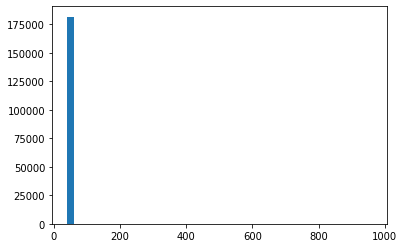

In [ ]:
removeNoiseData(dados_acoes , dados_acoes["fator_cotacao"] , 0.2)

In [ ]:
dados_acoes.drop(["moeda_referencia"], axis=1, inplace=True)


In [ ]:
dados_acoes["empresa"].value_counts()

PETRE           10027
VALEE            6220
PETR             4858
BBASE            3892
MGLUE            3198
                ...  
THE JM SMUCK        1
FII JASC REN        1
BUMBLE INC          1
WEC ENERGY G        1
PPL CORP            1
Name: empresa, Length: 2176, dtype: int64

In [ ]:
dados_acoes["fator_cotacao"]

,tipo_registro,data_pregao,cod_bdi,cod_negociacao,tipo_mercado,empresa,especificacao_papel,moeda_referencia,preco_abertura,preco_maximo,...,preco_melhor_oferta_compra,preco_melhor_oferta_venda,numero_negocios,quantidade_papeis_negociados,volume_total_negociado,preco_exercicio,data_vencimento,fator_cotacao,codigo_isin,num_distribuicao_papel
0,1,20221003,2.0,ELMD3,10,ELETROMIDIA,ON NM,R$,10.80,11.73,...,11.40,11.44,680.0,216300.0,2469914.0,0.00,99991231.0,1.0,BRELMDACNOR3,100.0
1,1,20221003,2.0,OFSA3,10,OUROFINO S/A,ON NM,R$,23.17,23.17,...,22.50,22.75,37.0,7300.0,166458.0,0.00,99991231.0,1.0,BROFSAACNOR7,114.0
2,1,20221003,2.0,SMFT3,10,SMART FIT,ON NM,R$,15.68,16.60,...,16.07,16.12,8482.0,1950600.0,31486931.0,0.00,99991231.0,1.0,BRSMFTACNOR1,109.0
3,1,20221003,2.0,HOME34,10,HOME DEPOT,DRN,R$,52.53,52.84,...,51.12,52.76,494.0,27860.0,1467963.7,0.00,99991231.0,1.0,BRHOMEBDR002,143.0
4,1,20221003,2.0,BRGE3,10,ALFA CONSORC,ON,R$,9.95,9.95,...,9.00,9.70,2.0,200.0,1912.0,0.00,99991231.0,1.0,BRBRGEACNOR6,203.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
181801,1,20221018,78.0,ITSAI99,70,ITSA,PN N1,R$,2.37,2.37,...,2.43,3.00,1.0,1000.0,2370.0,9.06,20230915.0,1.0,BRITSAACNPR7,412.0
181802,1,20221019,78.0,ITSAI99,70,ITSA,PN N1,R$,2.43,2.43,...,0.06,3.00,3.0,1500.0,3639.0,9.06,20230915.0,1.0,BRITSAACNPR7,412.0
181803,1,20221021,78.0,ITSAI99,70,ITSA,PN N1,R$,2.68,2.68,...,2.74,0.00,1.0,500.0,1340.0,9.06,20230915.0,1.0,BRITSAACNPR7,412.0
181804,1,20221024,78.0,ITSAI99,70,ITSA,PN N1,R$,2.59,2.59,...,2.00,3.23,1.0,1000.0,2590.0,9.06,20230915.0,1.0,BRITSAACNPR7,412.0


In [ ]:
empresa_1 = dados_acoes[dados_acoes["empresa"] == "PETRE"]

In [ ]:
empresa_1

,tipo_registro,data_pregao,cod_bdi,cod_negociacao,tipo_mercado,empresa,especificacao_papel,prazo_dias_merc_termo,preco_abertura,preco_maximo,...,numero_negocios,quantidade_papeis_negociados,volume_total_negociado,preco_exercicio,ìndicador_correcao_precos,data_vencimento,fator_cotacao,preco_exercicio_pontos,codigo_isin,num_distribuicao_papel
56292,1,20221004,82.0,PETRW358,80,PETRE,ON N2,0.0,0.48,0.48,...,15.0,7500.0,3597.0,29.18,0.0,20221118.0,1.0,0.0,BRPETRACNOR9,196.0
56293,1,20221005,82.0,PETRW358,80,PETRE,ON N2,0.0,0.48,0.48,...,2.0,2000.0,900.0,29.18,0.0,20221118.0,1.0,0.0,BRPETRACNOR9,196.0
56294,1,20221006,82.0,PETRW358,80,PETRE,ON N2,0.0,0.36,0.36,...,3.0,6000.0,1530.0,29.18,0.0,20221118.0,1.0,0.0,BRPETRACNOR9,196.0
56295,1,20221007,82.0,PETRW358,80,PETRE,ON N2,0.0,0.23,0.29,...,17.0,15200.0,3775.0,29.18,0.0,20221118.0,1.0,0.0,BRPETRACNOR9,196.0
56296,1,20221011,82.0,PETRW358,80,PETRE,ON N2,0.0,0.30,0.30,...,1.0,3000.0,900.0,29.18,0.0,20221118.0,1.0,0.0,BRPETRACNOR9,196.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
180713,1,20221026,78.0,PETRK822,70,PETRE,PN N2,0.0,24.17,25.10,...,12.0,1200.0,29424.0,8.22,0.0,20221118.0,1.0,0.0,BRPETRACNPR6,204.0
180714,1,20221028,78.0,PETRK822,70,PETRE,PN N2,0.0,24.39,24.39,...,5.0,500.0,12087.0,8.22,0.0,20221118.0,1.0,0.0,BRPETRACNPR6,204.0
180715,1,20221031,78.0,PETRK822,70,PETRE,PN N2,0.0,22.12,22.12,...,3.0,300.0,6534.0,8.22,0.0,20221118.0,1.0,0.0,BRPETRACNPR6,204.0
180721,1,20221013,78.0,PETRC374,70,PETRE,PN N2,0.0,2.67,2.67,...,1.0,10000.0,26700.0,37.52,0.0,20230317.0,1.0,0.0,BRPETRACNPR6,204.0


## Como estão centrados os preços dos últimos negocios da PETRE?

#### Primeiro os dados dos preços do últimos negócios serão alocados para um objeto Series unidimensional 

In [ ]:
PETRE = empresa_1["preco_ultimo_negocio"]
PETRE_arr = np.array(PETRE)
type(PETRE)
type(PETRE_arr)

#Ordenar preço dos últimos negócios da PETRE
PETRE_arr.sort()
print(PETRE_arr)

[1.000e-02 1.000e-02 1.000e-02 ... 4.877e+01 4.927e+01 4.977e+01]


In [ ]:
PETRE.describe()

count    10027.000000
mean         4.105726
std          5.729424
min          0.010000
25%          0.240000
50%          1.700000
75%          5.750000
max         49.770000
Name: preco_ultimo_negocio, dtype: float64

#### O dicionário "central_tendency_measures" contém dados das medidas de tendência central do Series em questão

In [ ]:
from scipy.stats import variation
central_tendency_measures = {
    "mean": PETRE.mean(),
    "mode": PETRE.mode(dropna = True),
    "median": PETRE.median(), 
    "max": PETRE.max(),
    "min": PETRE.min(),
}
pd.Series(central_tendency_measures)

mean                      4.105726
mode      0    0.01
dtype: float64
median                         1.7
max                          49.77
min                           0.01
dtype: object

## Como estão distribuídos os preços das ações da PETRE?


#### Variability Measures
Existe uniformidade entre as medidas encontradas?

In [ ]:
def shifting_range(numpy_arr):
    input_arr = numpy_arr
    print(np.roll(input_arr, 1))
# note que os elementos foram "deslizados" 
# uma casa para a direita, com o último elemento
# dando a volta e aparecendo na primeira casa
    output_arr = input_arr - np.roll(input_arr, 1)  # subtração de vetores
    return output_arr
# output: [ 1  1  0  4 -5]
variability_measures = {
    "variance" : PETRE.var(),
    "standard deviation": PETRE.std(),
    "shifiting_range" : np.unique(shifting_range(PETRE_arr)),
    "CV" : variation(PETRE)
}
pd.Series(variability_measures)


[4.977e+01 1.000e-02 1.000e-02 ... 4.827e+01 4.877e+01 4.927e+01]


variance                                                      32.826294
standard deviation                                             5.729424
shifiting_range       [-49.760000000000005, 0.0, 0.00999999999999801...
CV                                                             1.395402
dtype: object

#### A média está centralizada?


In [ ]:
#Criar um gráfico que
    #Exibe a diferença entre o coeficiente de variação, a média e o desvio padrão
    

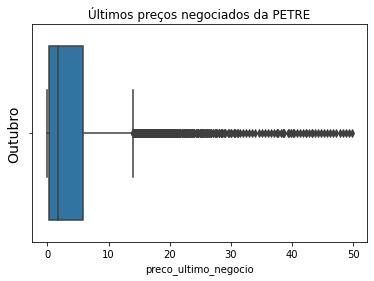

In [ ]:
boxplot_empresa1_precoultimo_plt = sns.boxplot(x=empresa_1["preco_ultimo_negocio"]) # colocando o boxplot numa variável para manipular melhor
boxplot_empresa1_precoultimo_plt.set_ylabel('Outubro', fontsize=14) # Aqui você renomeia o eixo que deseja e o tamanho da fonte

boxplot_empresa1_precoultimo_plt.plot() # Aqui é como se o gráfico fosse ocultado até ser usado plt.show()

# em R$ - Reais
plt.title('Últimos preços negociados da PETRE') # O título que se deseja colocar acima do gráfico

plt.show() # Impressão do gráfico

In [ ]:
empresa_1["volume_total_negociado"].std()

6105593.487115127

In [ ]:
empresa_1["volume_total_negociado"].mean()

710625.8090156578

In [ ]:
empresa_1["volume_total_negociado"].median()

38973.0

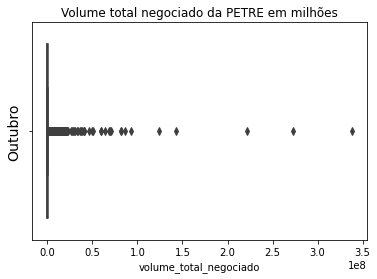

In [ ]:
boxplot_empresa1_volumetotal_plt = sns.boxplot(x=empresa_1["volume_total_negociado"])
boxplot_empresa1_volumetotal_plt.set_ylabel('Outubro', fontsize=14)

boxplot_empresa1_volumetotal_plt.plot()


plt.title('Volume total negociado da PETRE em milhões')

plt.show()

In [ ]:
empresa_1["numero_negocios"].std()

384.4783561749843

In [ ]:
empresa_1["numero_negocios"].mean()

124.9536252119278

In [ ]:
empresa_1["numero_negocios"].median()

13.0

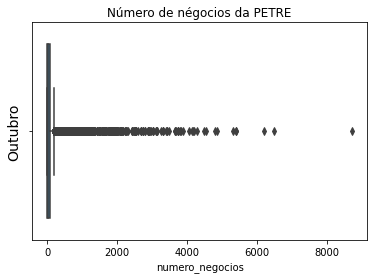

In [ ]:
boxplot_empresa1_numeronegocios_plt = sns.boxplot(x=empresa_1["numero_negocios"])
boxplot_empresa1_numeronegocios_plt.set_ylabel('Outubro', fontsize=14)

boxplot_empresa1_numeronegocios_plt.plot()


plt.title('Número de négocios da PETRE')

plt.show()

In [ ]:
empresa_1["preco_maximo"].std()

5.776885233996003

In [ ]:
empresa_1["preco_maximo"].mean()

4.266220205445298

In [ ]:
empresa_1["preco_maximo"].median()

1.9

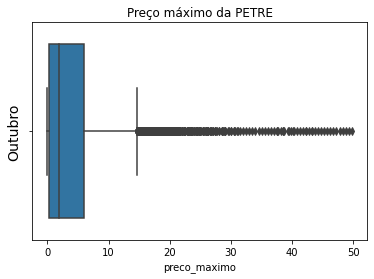

In [ ]:
boxplot_empresa1_maximo_plt = sns.boxplot(x = empresa_1["preco_maximo"])
boxplot_empresa1_maximo_plt.set_ylabel('Outubro', fontsize=14)

boxplot_empresa1_maximo_plt.plot()


plt.title('Preço máximo da PETRE') # em R$ - Reais

plt.show()

In [ ]:
empresa_1["preco_minimo"].std()

5.660947624318514

In [ ]:
empresa_1["preco_minimo"].mean()

3.9287164655430344

In [ ]:
empresa_1["preco_minimo"].median()

1.5

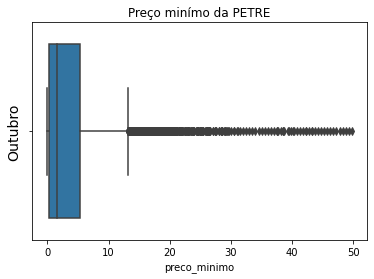

In [ ]:
boxplot_empresa1_minimo_plt = sns.boxplot(x = empresa_1["preco_minimo"])
boxplot_empresa1_minimo_plt.set_ylabel('Outubro', fontsize=14)

boxplot_empresa1_minimo_plt.plot()


plt.title('Preço minímo da PETRE') # em R$ - Reais

plt.show()

In [ ]:
empresa_1["preco_abertura"].std()

5.707135405067762

In [ ]:
empresa_1["preco_abertura"].mean()

4.093392839333799

In [ ]:
empresa_1["preco_abertura"].median()

1.71

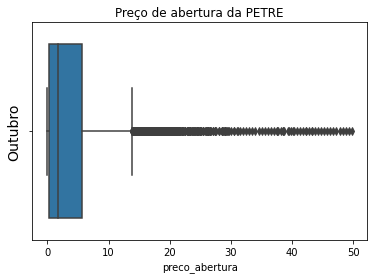

In [ ]:
boxplot_empresa1_abertura_plt = sns.boxplot(x = empresa_1["preco_abertura"])
boxplot_empresa1_abertura_plt.set_ylabel('Outubro', fontsize=14)

boxplot_empresa1_abertura_plt.plot()


plt.title('Preço de abertura da PETRE') # em R$ - Reais

plt.show()